The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install git+https://github.com/d2l-ai/d2l-zh@release  # installing d2l


# Adadelta
:label:`sec_adadelta`


Adadelta是AdaGrad的另一种变体（ :numref:`sec_adagrad`），
主要区别在于前者减少了学习率适应坐标的数量。
此外，广义上Adadelta被称为没有学习率，因为它使用变化量本身作为未来变化的校准。
Adadelta算法是在 :cite:`Zeiler.2012`中提出的。

## Adadelta算法

简而言之，Adadelta使用两个状态变量，$\mathbf{s}_t$用于存储梯度二阶导数的漏平均值，$\Delta\mathbf{x}_t$用于存储模型本身中参数变化二阶导数的泄露平均值。请注意，为了与其他出版物和实现的兼容性，我们使用作者的原始符号和命名（没有其他真正理由为什么应该使用不同的希腊变量来表示在动量中用于相同用途的参数，即AdaGrad、RMSProp和Adadelta）。

以下是Adadelta的技术细节。鉴于参数du jour是$\rho$，我们获得了与 :numref:`sec_rmsprop`类似的以下泄漏更新：

$$\begin{aligned}
    \mathbf{s}_t & = \rho \mathbf{s}_{t-1} + (1 - \rho) \mathbf{g}_t^2.
\end{aligned}$$

与 :numref:`sec_rmsprop`的区别在于，我们使用重新缩放的梯度$\mathbf{g}_t'$执行更新，即

$$\begin{aligned}
    \mathbf{x}_t  & = \mathbf{x}_{t-1} - \mathbf{g}_t'. \\
\end{aligned}$$

那么，调整后的梯度$\mathbf{g}_t'$是什么？我们可以按如下方式计算它：

$$\begin{aligned}
    \mathbf{g}_t' & = \frac{\sqrt{\Delta\mathbf{x}_{t-1} + \epsilon}}{\sqrt{{\mathbf{s}_t + \epsilon}}} \odot \mathbf{g}_t, \\
\end{aligned}$$

其中$\Delta \mathbf{x}_{t-1}$是重新缩放梯度的平方$\mathbf{g}_t'$的泄漏平均值。我们将$\Delta \mathbf{x}_{0}$初始化为$0$，然后在每个步骤中使用$\mathbf{g}_t'$更新它，即

$$\begin{aligned}
    \Delta \mathbf{x}_t & = \rho \Delta\mathbf{x}_{t-1} + (1 - \rho) {\mathbf{g}_t'}^2,
\end{aligned}$$

和$\epsilon$（例如$10^{-5}$这样的小值）是为了保持数字稳定性而加入的。

## 代码实现

Adadelta需要为每个变量维护两个状态变量，即$\mathbf{s}_t$和$\Delta\mathbf{x}_t$。这将产生以下实施。


In [1]:
%matplotlib inline
import tensorflow as tf
from d2l import tensorflow as d2l


def init_adadelta_states(feature_dim):
    s_w = tf.Variable(tf.zeros((feature_dim, 1)))
    s_b = tf.Variable(tf.zeros(1))
    delta_w = tf.Variable(tf.zeros((feature_dim, 1)))
    delta_b = tf.Variable(tf.zeros(1))
    return ((s_w, delta_w), (s_b, delta_b))

def adadelta(params, grads, states, hyperparams):
    rho, eps = hyperparams['rho'], 1e-5
    for p, (s, delta), grad in zip(params, states, grads):
        s[:].assign(rho * s + (1 - rho) * tf.math.square(grad))
        g = (tf.math.sqrt(delta + eps) / tf.math.sqrt(s + eps)) * grad
        p[:].assign(p - g)
        delta[:].assign(rho * delta + (1 - rho) * g * g)

对于每次参数更新，选择$\rho = 0.9$相当于10个半衰期。由此我们得到：


loss: 0.243, 0.094 sec/epoch


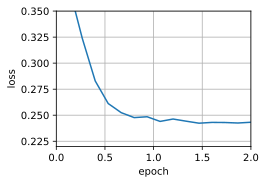

In [2]:
data_iter, feature_dim = d2l.get_data_ch11(batch_size=10)
d2l.train_ch11(adadelta, init_adadelta_states(feature_dim),
               {'rho': 0.9}, data_iter, feature_dim);

为了简洁实现，我们只需使用`Trainer`类中的`adadelta`算法。


loss: 0.243, 0.075 sec/epoch


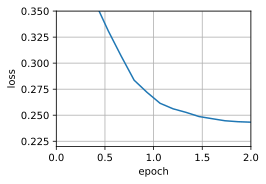

In [3]:
# adadelta is not converging at default learning rate
# but it's converging at lr = 5.0
trainer = tf.keras.optimizers.Adadelta
d2l.train_concise_ch11(trainer, {'learning_rate':5.0, 'rho': 0.9}, data_iter)

## 小结

* Adadelta没有学习率参数。相反，它使用参数本身的变化率来调整学习率。
* Adadelta需要两个状态变量来存储梯度的二阶导数和参数的变化。
* Adadelta使用泄漏的平均值来保持对适当统计数据的运行估计。

## 练习

1. 调整$\rho$的值，会发生什么？
1. 展示如何在不使用$\mathbf{g}_t'$的情况下实现算法。为什么这是个好主意？
1. Adadelta真的是学习率为0吗？你能找到Adadelta无法解决的优化问题吗？
1. 将Adadelta的收敛行为与AdaGrad和RMSProp进行比较。


[Discussions](https://discuss.d2l.ai/t/1077)
